We consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes 𝑌 as normally-distributed observations with an expected value 𝜇 that is a linear function of two predictor variables, $𝑋_1$ and $𝑋_2.$
$$\begin{split}\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}\end{split}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i,$ while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to weak information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma.$ The priors are
$$\begin{split}\begin{aligned}
\alpha &\sim \mathcal{N}(0, 100) ,\\
\beta_i &\sim \mathcal{N}(0, 100) ,\\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}.
\end{aligned}\end{split}$$


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

We simulate data from this model using only NumPy’s random module, and then use PyMC3 to recover the corresponding parameters.

In [2]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

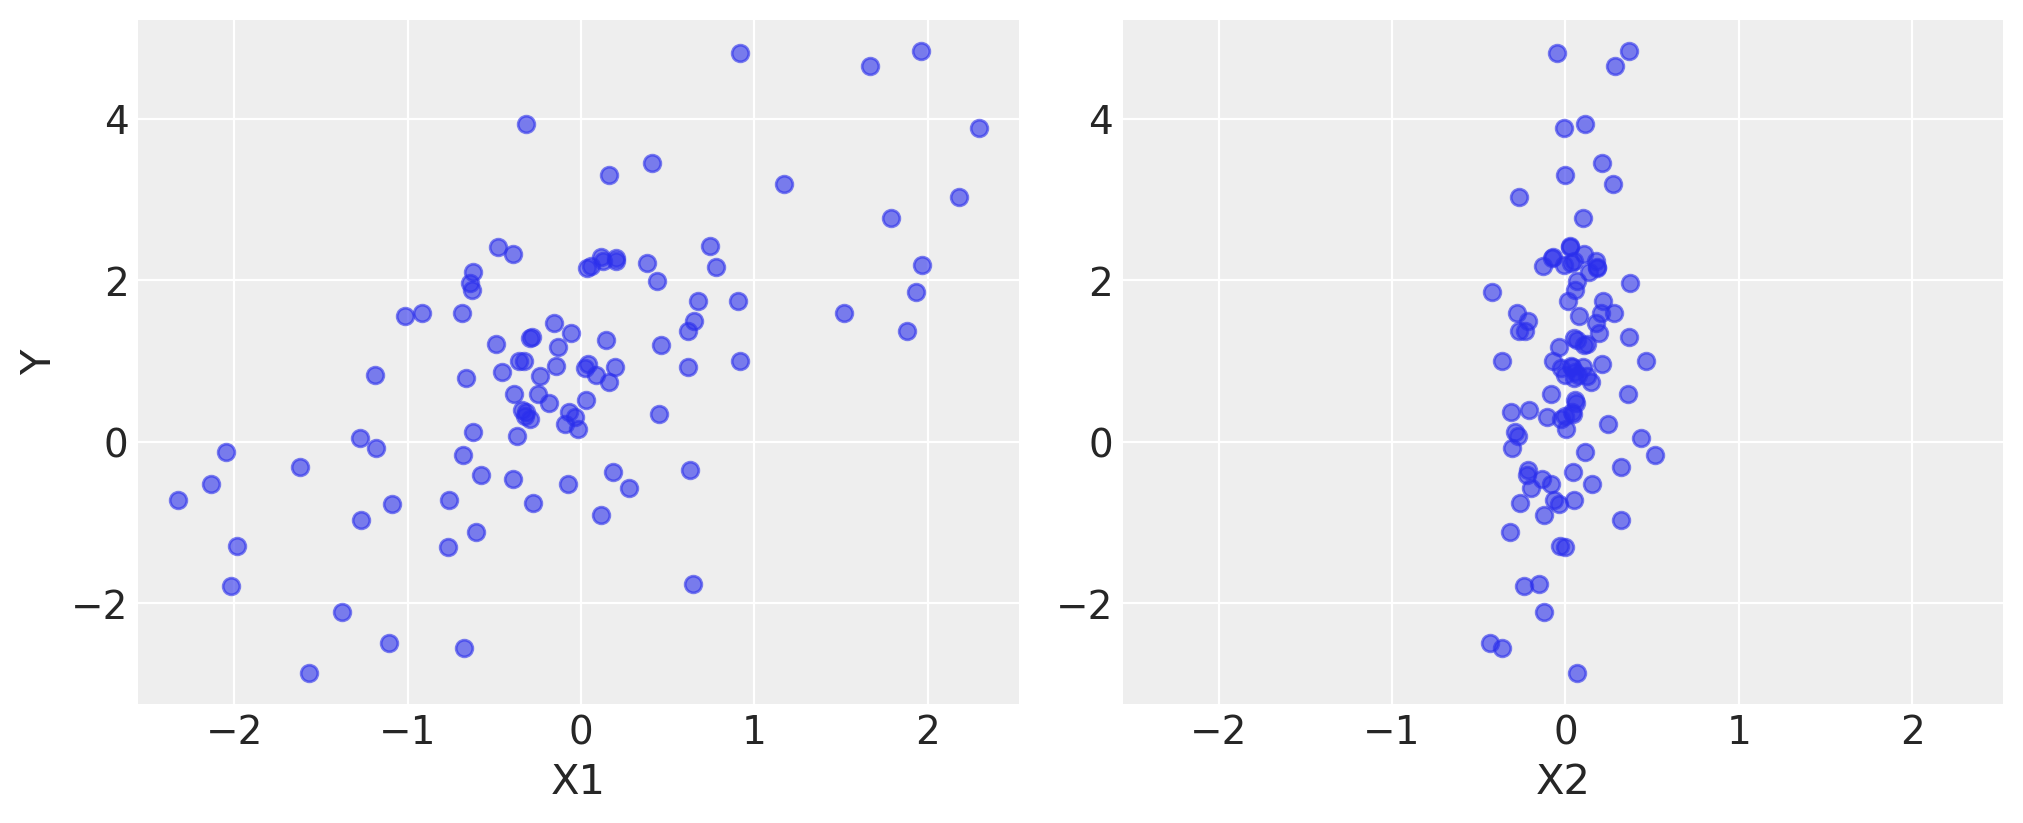

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");
plt.savefig('PP-LR2var-data.png',dpi=600)

The specification this linear model in PyMC3 is straightforward. The syntax just repeats the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

In [5]:
import pymc3 as pm

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta  = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [12]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 19 seconds.


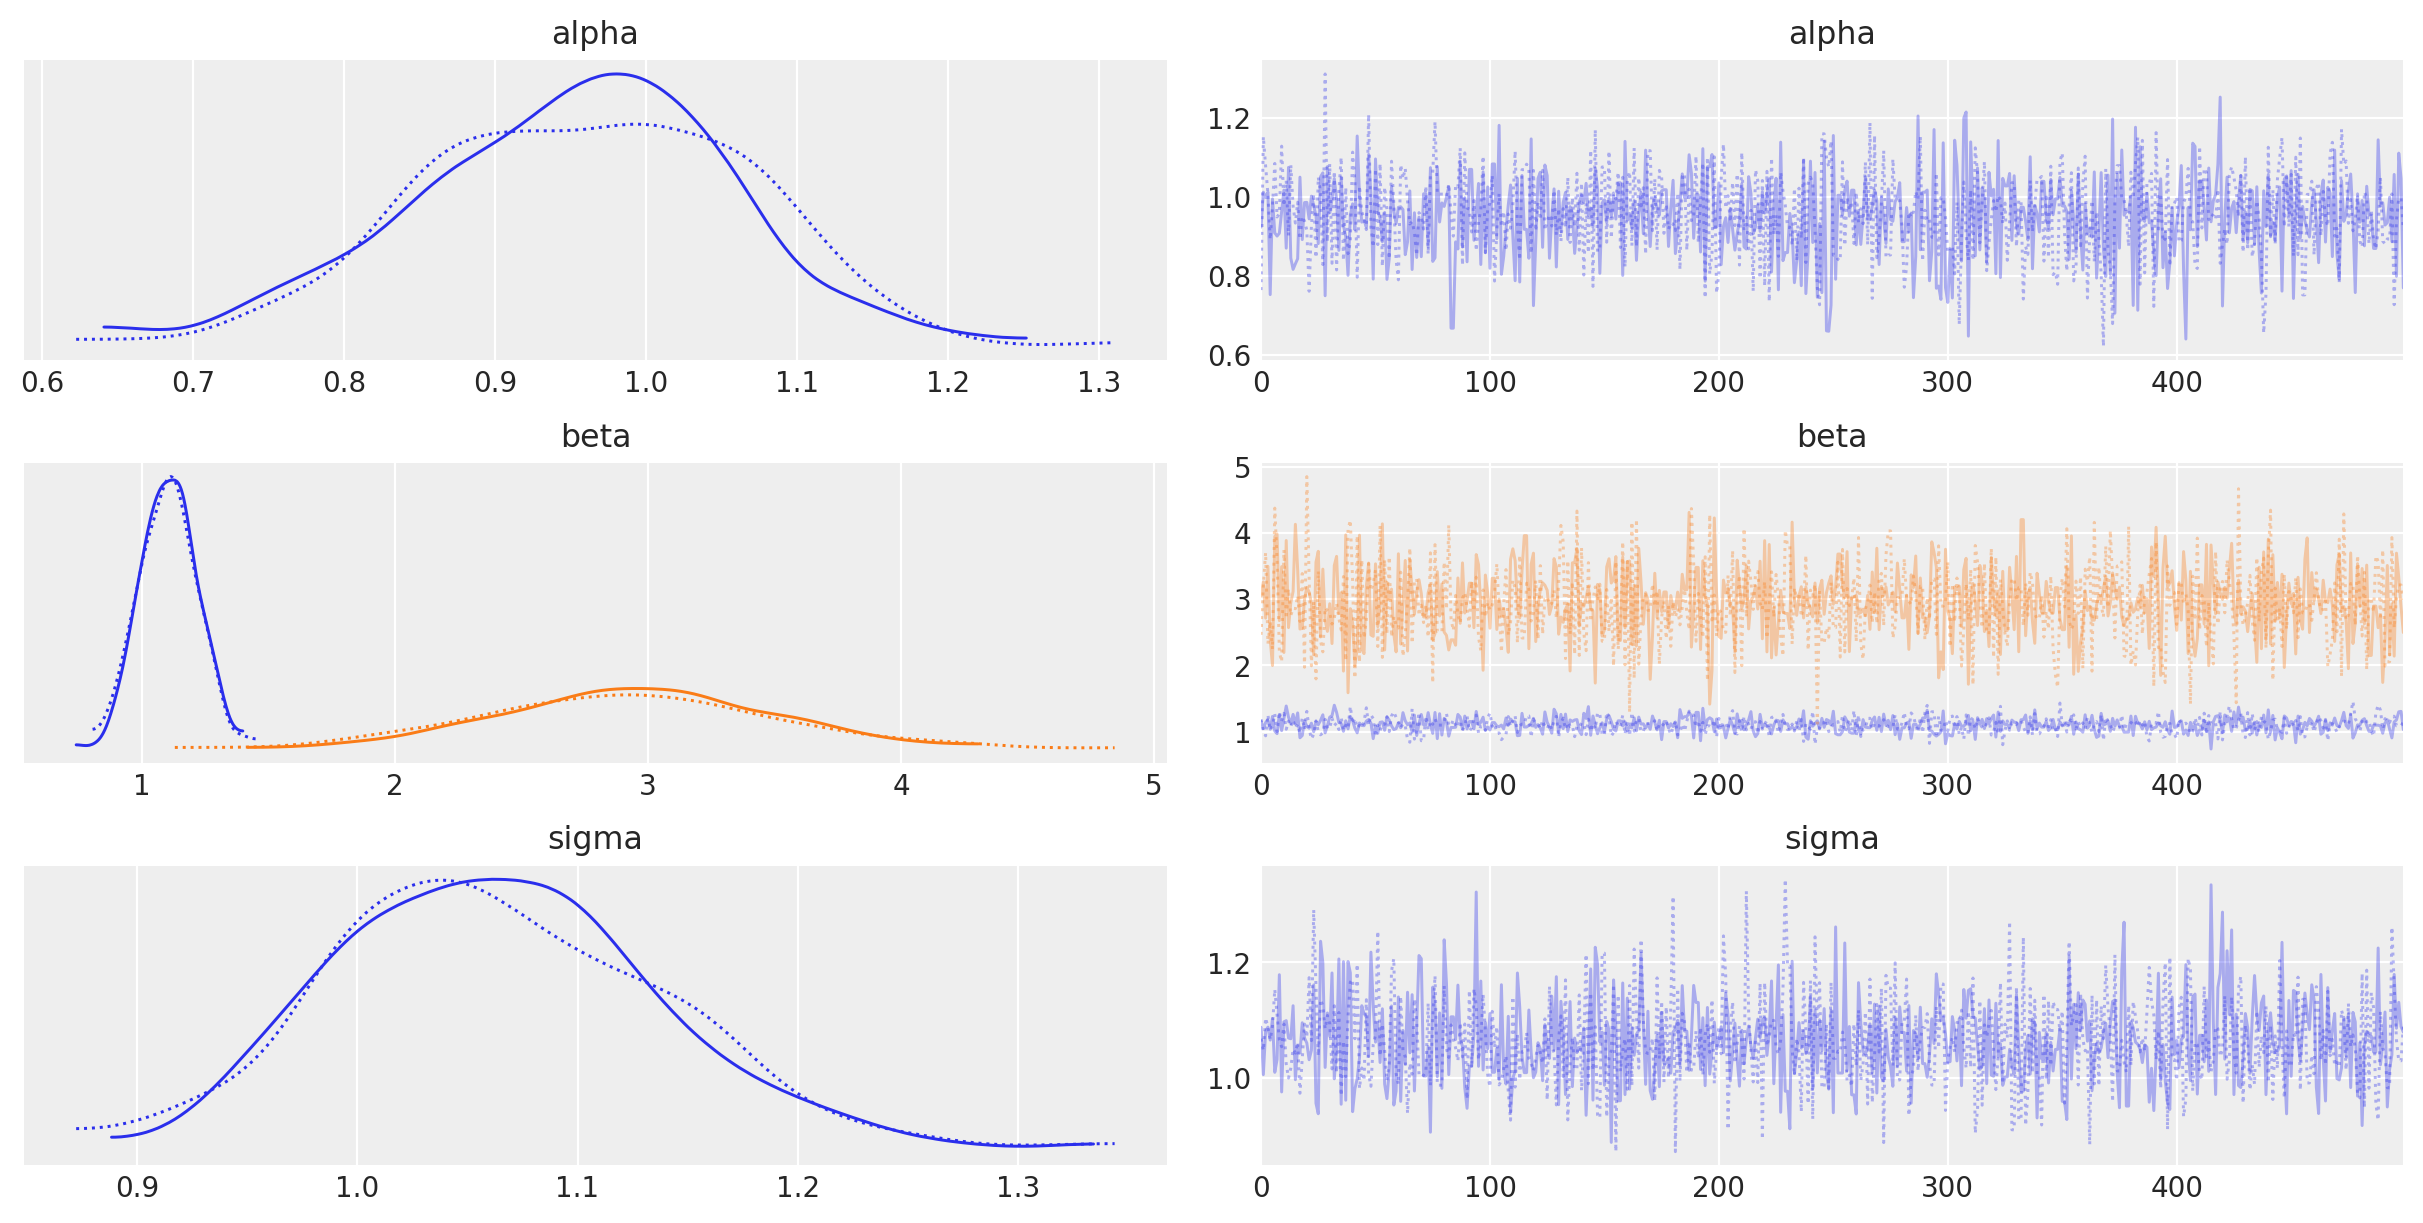

In [13]:
with basic_model:
    az.plot_trace(trace);
plt.savefig('PP-LR2var-trace.png',dpi=600)

The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a `Trace` object containing the samples collected, in the order they were collected. 

If we want to use the slice sampling algorithm for sigma, instead of NUTS (which was assigned automatically), we must specify this as the step argument for sample.

In [14]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 27 seconds.


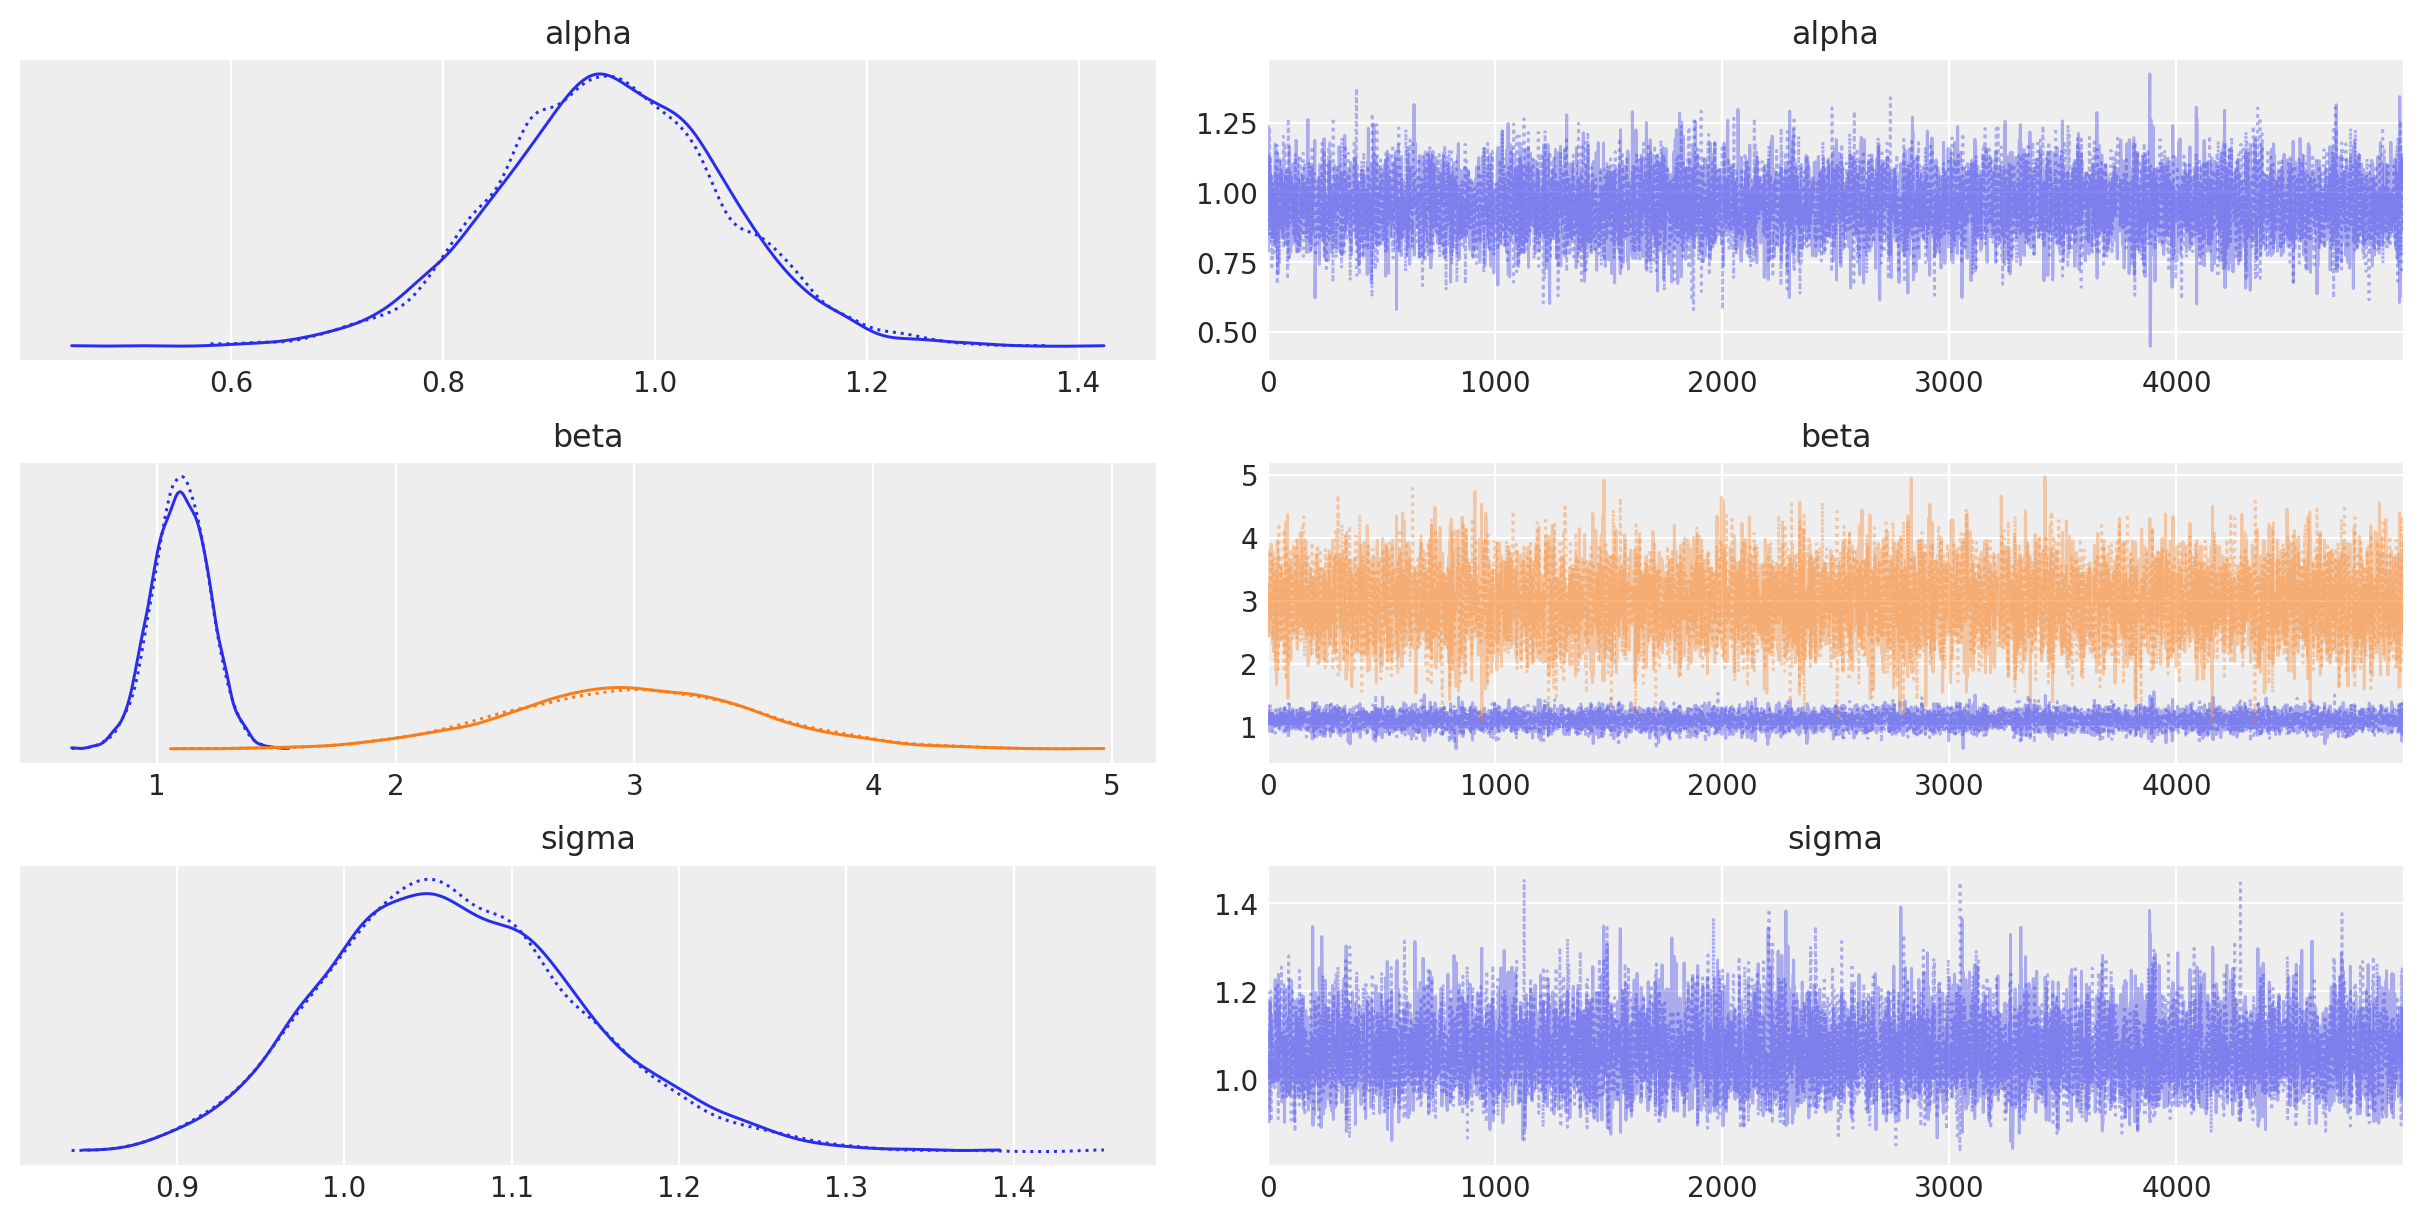

In [15]:
with basic_model:
    az.plot_trace(trace);
plt.savefig('PP-LR2var-trace2.png',dpi=600)

In [16]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.96,0.11,0.75,1.16,0.00,0.0,9959.92,6856.52,1.0
beta[0],1.10,0.12,0.89,1.33,0.00,0.0,9948.67,7394.03,1.0
beta[1],2.99,0.53,2.00,3.98,0.01,0.0,8378.47,6592.25,1.0
sigma,1.07,0.08,0.93,1.22,0.00,0.0,8498.12,6496.28,1.0


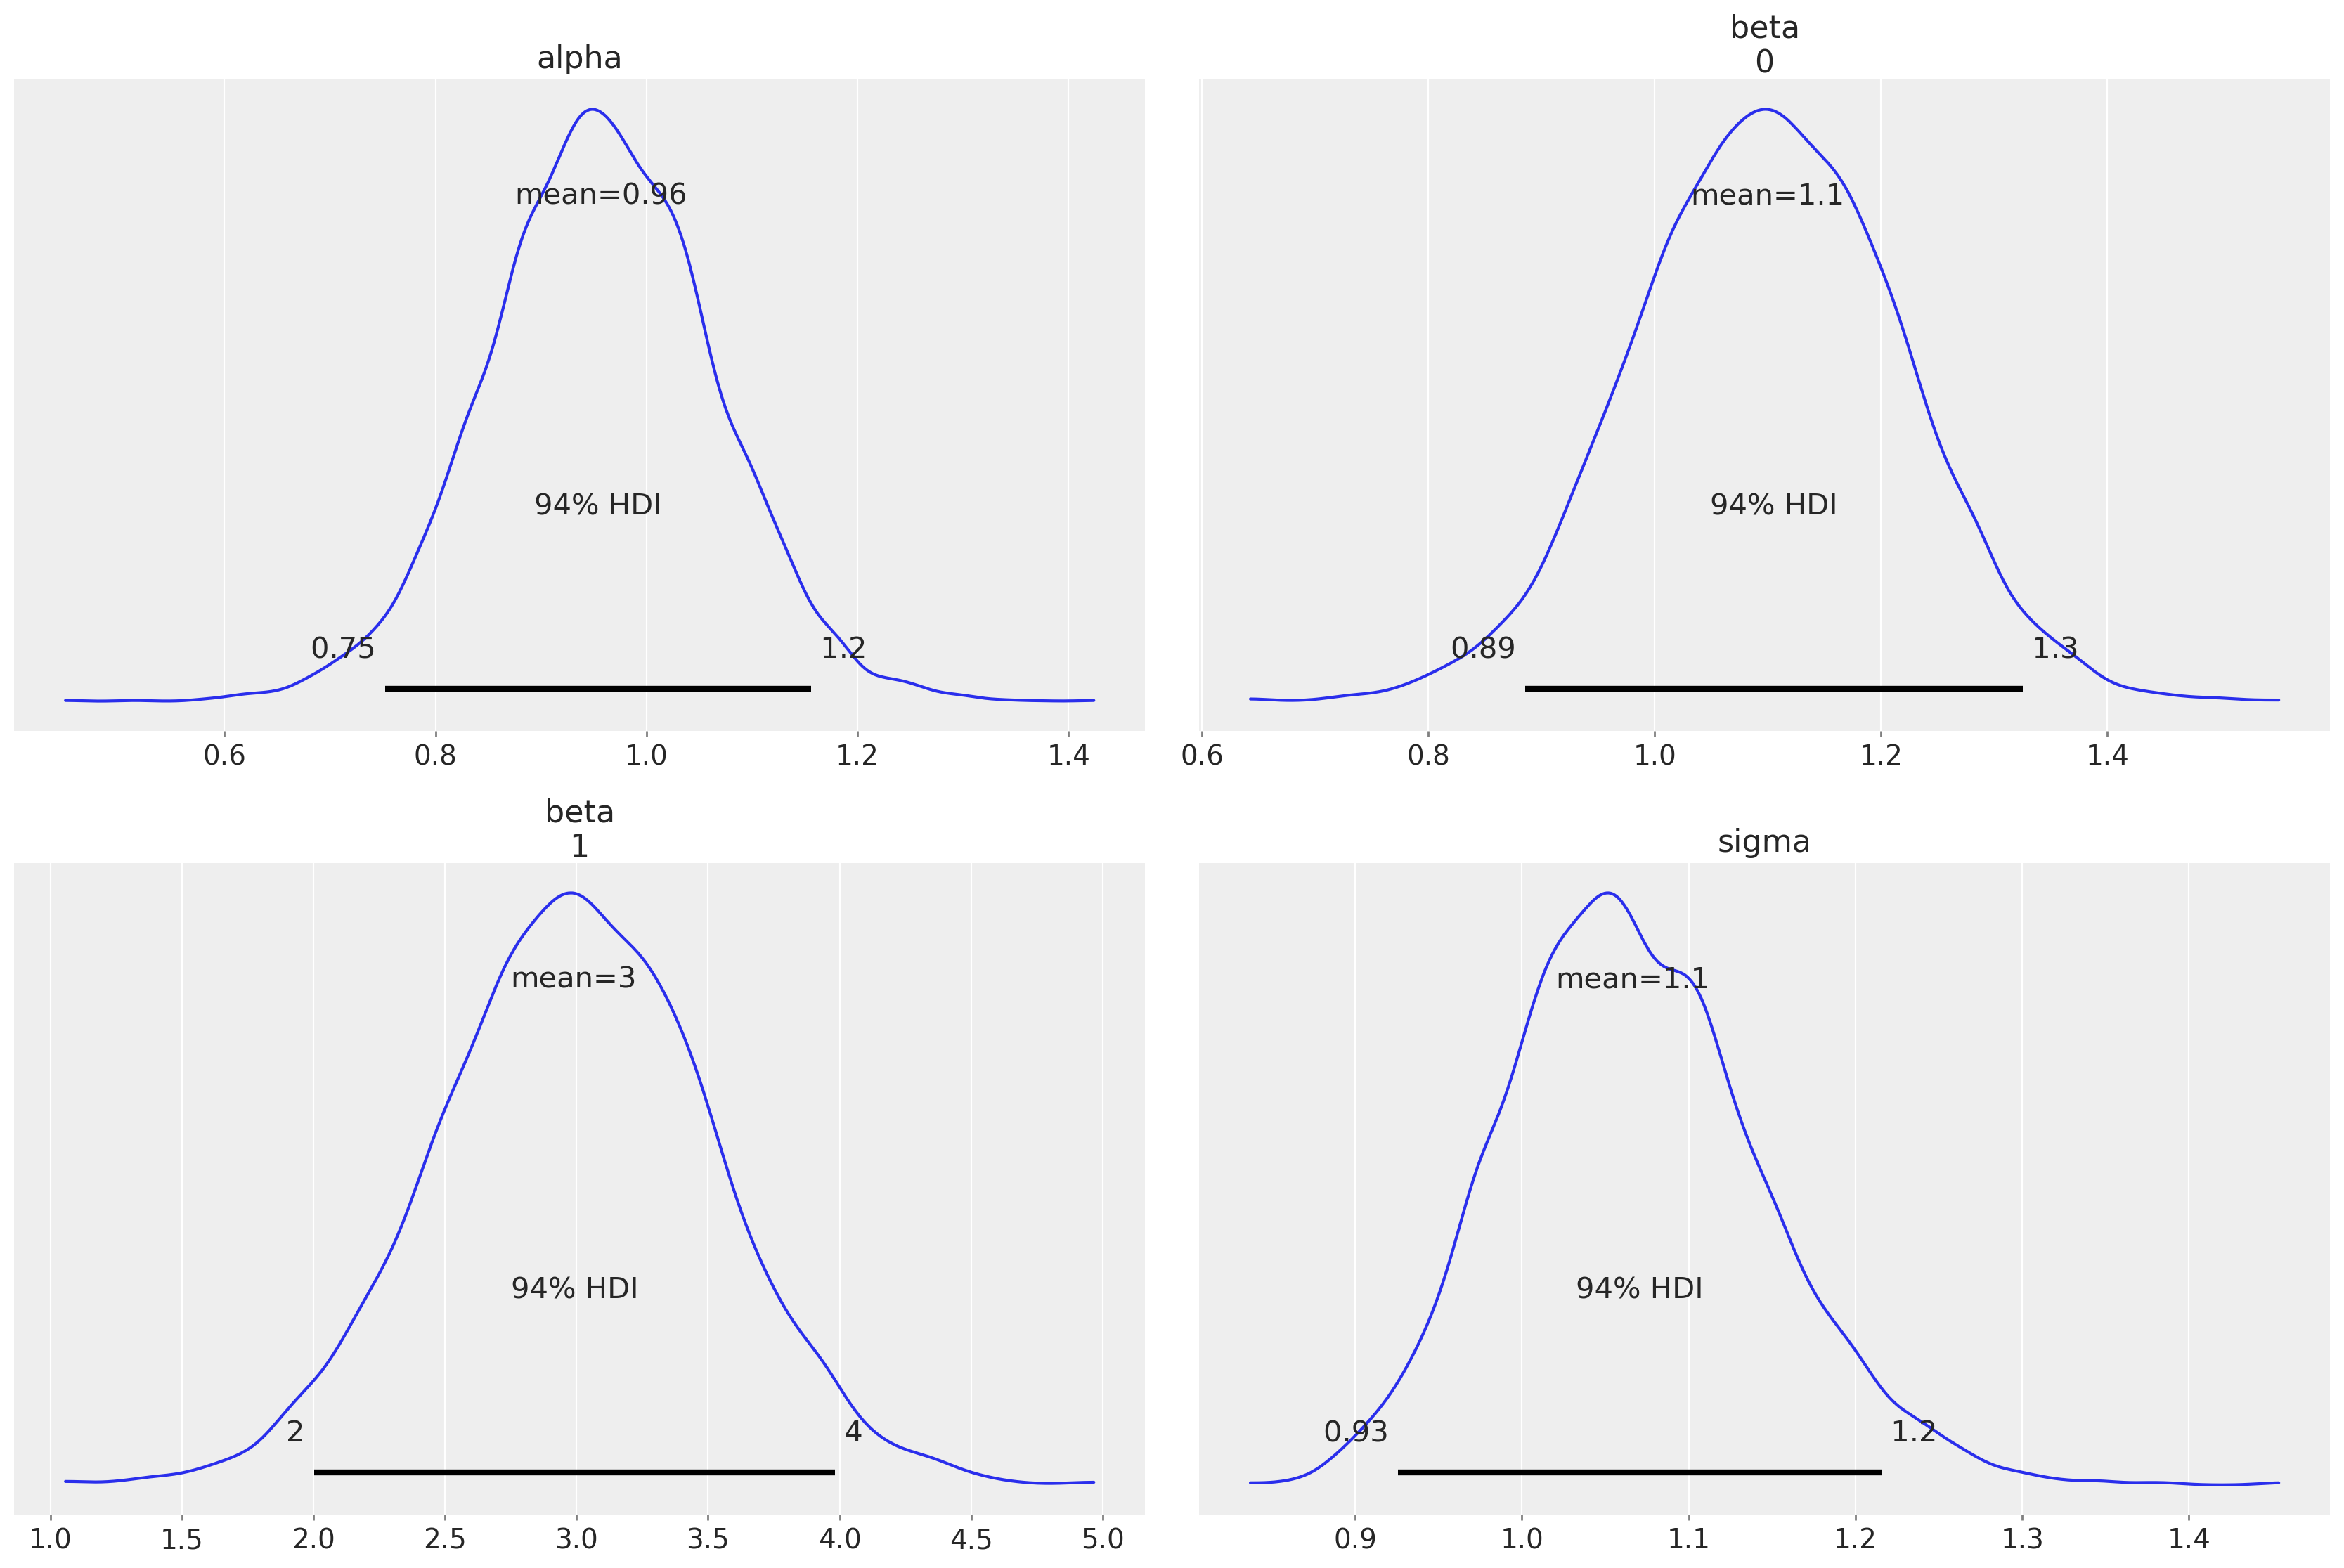

In [19]:
with basic_model:
    az.plot_posterior(trace,grid=(2,2));
plt.savefig('PP-LR2var-post.png',dpi=600)